In [14]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from utils import parse_date, match_dates_based_on_precision
import spacy
from glob import glob

In [2]:
nlp = spacy.load('en_core_web_trf')

In [3]:
input_file = '../data/dpr-post-process-unified-qa-matched.jl'
annotated_file = '../data/questions-for-annotation-annotated.csv'
evaluation_input_file = '../data/annotated-questions-for-evaluation.tsv'
evaluation_output_file = '../data/eval_output/output.tsv-95000'

In [4]:
annotated_questions = set(pd.read_csv(annotated_file)['question'].unique())

In [5]:
len(annotated_questions)

100

In [6]:
all_questions = []
with open(input_file) as f:
    for line in f:
        j = json.loads(line.strip())
        answer = j['a']
        question = j['q']
        if answer < '2020-01-01':
            if question not in annotated_questions:
                all_questions.append(j)

In [7]:
len(all_questions)

13254

In [ ]:
questions_with_spacy_matched = []
for aq in all_questions:
    dpr_answers = aq['matched_dpr_answers']
    for da in dpr_answers:
        if da['matched']:
            aq['matched_dpr_answer'] = da['dpr_answer']
            aq.pop('matched_dpr_answers')
            questions_with_spacy_matched.append(aq)
            break
            

In [ ]:
len(questions_with_spacy_matched)

In [ ]:
questions_with_spacy_matched[560]

In [ ]:
train, test = train_test_split(questions_with_spacy_matched, test_size=0.25)

In [ ]:
print(len(train), len(test))

In [ ]:
train[3]

In [ ]:
month_dict = {
    '01': 'January',
    '02': 'February',
    '03': 'March',
    '04': 'April',
    '05': 'May',
    '06': 'June',
    '07': 'July',
    '08': 'August',
    '09': 'September',
    '10': 'October',
    '11': 'November',
    '12': 'December'
    
}

In [ ]:
def create_unified_qa_model_input_files(list_questions, file_name):
    o = open(file_name, 'w')
    for q in list_questions:
        question = q['q']
        year, month, day = q['a'].split('-')
        if int(day) < 10:
            day = day[1:]
        precision = q['precision']
        if precision == '9': # year
            answer = year
        elif precision == '10': # month
            answer = f"{month_dict[month]}, {year}"
        else:
            answer = f"{day} {month_dict[month]} {year}"
        dpr_a  = q['matched_dpr_answer'].split('\n')[1]
        o.write(f"{question}\\n{dpr_a}\t{answer}\n")
    o.close()
        

In [ ]:
create_unified_qa_model_input_files(train, '../data/unified_qa_input/train.tsv')

In [ ]:
create_unified_qa_model_input_files(test, '../data/unified_qa_input/test.tsv')

In [ ]:
def create_input_for_evaluation(annotated_file, evaluation_input_file):
    df = pd.read_csv(annotated_file)
    o = open(evaluation_input_file, 'w')
    for question, para in list(zip(df['question'], df['dpr_answer'])):
        fstring = f"{question}\\n{para}\n"
        o.write(fstring)
    o.close()
    

In [ ]:
create_input_for_evaluation(annotated_file, evaluation_input_file)

In [82]:
def calculate_accuracy(annotated_file, 
                       eval_file_pattern, 
                       evaluated_file=None, 
                       evaluated_dir=None, 
                       annotated_df=None):
    if annotated_df is None:
        annotated_df = pd.read_csv(annotated_file)
    if evaluated_file is not None:
        evaluations = []
        with open(evaluated_file) as f:
            for line in f:
                parsed_dates = parse_date(line.strip().replace('b', '').replace("'", ""), nlp, requires=['year'])
                if len(parsed_dates) > 0:
                    evaluations.append(parsed_dates[0])
                else:
                    evaluations.append('')
        copy_df = annotated_df.copy()
        copy_df['evaluation'] = evaluations
        matches = []
        for answer, precision, evaluation in list(zip(copy_df['answer'], 
                                                      copy_df['precision'], 
                                                      copy_df['evaluation'])):
            matched, prov = match_dates_based_on_precision(answer, precision, evaluation)
            matches.append(matched)
        copy_df['fine_tune_matches'] = matches
        num_1 = len(copy_df[(copy_df['fine_tune_matches'] == True) & (copy_df['answerable'] == 'yes')]) 
        num_2 = len(copy_df[copy_df['answerable'] == 'yes'])
        print(evaluated_file, num_1, num_2)
        return (float(num_1) / float(num_2)) * 100
    if evaluated_dir is not None:
        output = []
        files = glob(f'{evaluated_dir}/{eval_file_pattern}*')
        for fi in files:
            output.append({
                'file': fi.split('/')[-1],
                'accuracy': calculate_accuracy(annotated_file, eval_file_pattern, evaluated_file=fi, annotated_df=annotated_df)
            })
        return output    
    

In [ ]:
out = calculate_accuracy(annotated_file, 
                         evaluated_dir='/data/amandeep/Github/time-qualifier-prediction/data/eval_output')

In [51]:
out_df = pd.DataFrame(out)

In [54]:
out_df['epoch'] = out_df['file'].map(lambda x: int(x.split('-')[1]))

<AxesSubplot:xlabel='epoch'>

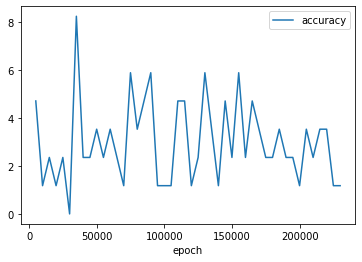

In [63]:
out_df.sort_values(by='epoch').plot(x='epoch', y='accuracy', kind='line')

In [ ]:
out_base = calculate_accuracy(annotated_file, evaluated_dir='/data/amandeep/Github/time-qualifier-prediction/data/eval_output')

In [69]:
out_base_df = pd.DataFrame(out_base)


<AxesSubplot:xlabel='epoch'>

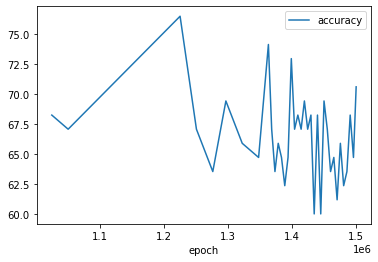

In [71]:
out_base_df['epoch'] = out_base_df['file'].map(lambda x: int(x.split('-')[2]))
out_base_df.sort_values(by='epoch').plot(x='epoch', y='accuracy', kind='line')

In [86]:
out_base_v2 = calculate_accuracy(annotated_file, 'output-base_v2.tsv-', evaluated_dir='/data/amandeep/Github/time-qualifier-prediction/data/eval_output')

/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


/data/amandeep/Github/time-qualifier-prediction/data/eval_output/output-base_v2.tsv-10000 1 85


/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


/data/amandeep/Github/time-qualifier-prediction/data/eval_output/output-base_v2.tsv-100000 3 85


/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


/data/amandeep/Github/time-qualifier-prediction/data/eval_output/output-base_v2.tsv-105000 2 85


/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


/data/amandeep/Github/time-qualifier-prediction/data/eval_output/output-base_v2.tsv-110000 2 85


/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


/data/amandeep/Github/time-qualifier-prediction/data/eval_output/output-base_v2.tsv-115000 1 85


/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


/data/amandeep/Github/time-qualifier-prediction/data/eval_output/output-base_v2.tsv-120000 2 85


/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


/data/amandeep/Github/time-qualifier-prediction/data/eval_output/output-base_v2.tsv-125000 2 85


/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


/data/amandeep/Github/time-qualifier-prediction/data/eval_output/output-base_v2.tsv-130000 2 85


/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


/data/amandeep/Github/time-qualifier-prediction/data/eval_output/output-base_v2.tsv-135000 1 85


/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


/data/amandeep/Github/time-qualifier-prediction/data/eval_output/output-base_v2.tsv-15000 1 85


/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


/data/amandeep/Github/time-qualifier-prediction/data/eval_output/output-base_v2.tsv-20000 3 85


/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


/data/amandeep/Github/time-qualifier-prediction/data/eval_output/output-base_v2.tsv-25000 2 85


/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


/data/amandeep/Github/time-qualifier-prediction/data/eval_output/output-base_v2.tsv-30000 1 85


/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


/data/amandeep/Github/time-qualifier-prediction/data/eval_output/output-base_v2.tsv-35000 1 85


/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


/data/amandeep/Github/time-qualifier-prediction/data/eval_output/output-base_v2.tsv-40000 0 85


/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


/data/amandeep/Github/time-qualifier-prediction/data/eval_output/output-base_v2.tsv-45000 1 85


/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


/data/amandeep/Github/time-qualifier-prediction/data/eval_output/output-base_v2.tsv-5000 5 85


/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


/data/amandeep/Github/time-qualifier-prediction/data/eval_output/output-base_v2.tsv-50000 0 85


/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


/data/amandeep/Github/time-qualifier-prediction/data/eval_output/output-base_v2.tsv-55000 1 85


/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


/data/amandeep/Github/time-qualifier-prediction/data/eval_output/output-base_v2.tsv-60000 1 85


/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


/data/amandeep/Github/time-qualifier-prediction/data/eval_output/output-base_v2.tsv-65000 1 85


/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


/data/amandeep/Github/time-qualifier-prediction/data/eval_output/output-base_v2.tsv-70000 2 85


/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


/data/amandeep/Github/time-qualifier-prediction/data/eval_output/output-base_v2.tsv-75000 2 85


/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


/data/amandeep/Github/time-qualifier-prediction/data/eval_output/output-base_v2.tsv-80000 4 85


/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


/data/amandeep/Github/time-qualifier-prediction/data/eval_output/output-base_v2.tsv-85000 2 85


/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


/data/amandeep/Github/time-qualifier-prediction/data/eval_output/output-base_v2.tsv-90000 2 85


/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/nas/home/amandeep/miniconda3/envs/python3/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


/data/amandeep/Github/time-qualifier-prediction/data/eval_output/output-base_v2.tsv-95000 4 85


In [87]:
out_base_v2_df = pd.DataFrame(out_base_v2)

<AxesSubplot:xlabel='epoch'>

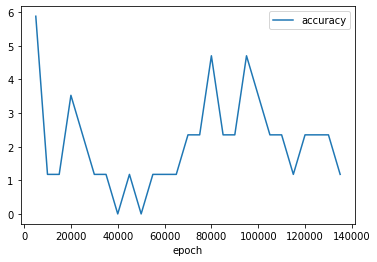

In [88]:
out_base_v2_df['epoch'] = out_base_v2_df['file'].map(lambda x: int(x.split('-')[2]))
out_base_v2_df.sort_values(by='epoch').plot(x='epoch', y='accuracy', kind='line')